In [5]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
data = {
    "state": ["CA", "WA", "CA", np.nan, "NV", "WA"],
    "gender": ["male", "female", "female", "male", np.nan, "female"],
    "age": [34, 29, 22, 44, 55, np.nan],
    "weight": [122, 150, 130, np.nan, 140, 175],
    "target": [0, 1, 0, 1, 0, 1]
}
df = pd.DataFrame(data)
X = df.drop("target", axis=1)
y = df["target"]


numeric_preprocessor = Pipeline(
    steps=[
        ("imputation_mean", SimpleImputer(missing_values=np.nan, strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

categorical_preprocessor = Pipeline(
    steps=[
        (
            "imputation_constant",
            SimpleImputer(fill_value="missing", strategy="constant"),
        ),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, ["state", "gender"]),
        ("numerical", numeric_preprocessor, ["age", "weight"]),
    ]
)

pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=500))
pipe  # click on the diagram below to see the details of each step

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['state', 'gender']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'weight'])])),
                ('logisticregression', LogisticRegression(max_iter=500))])

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline to your training data
pipe.fit(X_train, y_train)

# Make predictions on the test set
predictions = pipe.predict(X_test)
predictions, y_test



(array([0, 1]),
 0    0
 1    1
 Name: target, dtype: int64)

Best parameter (CV score=0.874):
{'logistic__C': 21.54434690031882, 'pca__n_components': 60}


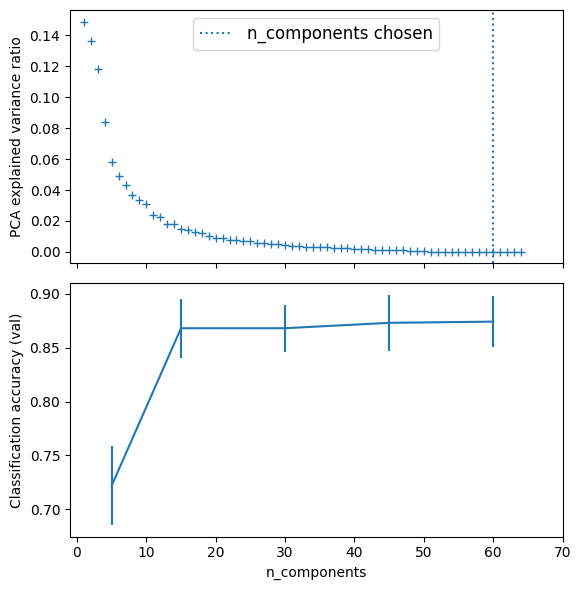

In [10]:
# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])

X_digits, y_digits = datasets.load_digits(return_X_y=True)
# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    "pca__n_components": [5, 15, 30, 45, 60],
    "logistic__C": np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X_digits)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")

ax0.axvline(
    search.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
)
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
components_col = "param_pca__n_components"
is_max_test_score = pl.col("mean_test_score") == pl.col("mean_test_score").max()
best_clfs = (
    pl.LazyFrame(search.cv_results_)
    .filter(is_max_test_score.over(components_col))
    .unique(components_col)
    .sort(components_col)
    .collect()
)
ax1.errorbar(
    best_clfs[components_col],
    best_clfs["mean_test_score"],
    yerr=best_clfs["std_test_score"],
)
ax1.set_ylabel("Classification accuracy (val)")
ax1.set_xlabel("n_components")

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()